In [17]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph
from libs.model import HGPforecaster, PiecewiseLinearChangepoints
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

import theano
theano.config.compute_test_value='raise'

In [18]:
police = pd.read_excel('../data/NIBRSPublicView.Jan1-Nov30-2020.xlsx')

In [19]:
police = police.drop(['Occurrence\nHour', 'StreetName', 'Suffix', 'NIBRSDescription', 'Premise'], axis=1)
police.columns = ['Id','Date', 'Crime', 'Count', 'Beat', 'Block', 'Street', 'City', 'ZIP']
police = police.drop(['Id'], axis=1)
police = police.loc[police['City']=='HOUSTON']
police = police.drop(['City'], axis=1)

In [20]:
# I am not using Block since there are 11901 blocks in the data
police = police.groupby(['Date', 'Crime', 'Beat', 'Street', 'ZIP']).sum().reset_index().set_index('Date')

In [21]:
police['ZIP'] = police.ZIP.astype(str)

In [22]:
# Removing ZIP
police = police.groupby(['Date', 'Crime', 'Beat', 'Street']).sum().reset_index().set_index('Date')

##### Using only the 100 series with larger number of counts

In [23]:
# Selecting the 100 groups combinations with higher counts

police = police.reset_index().set_index(['Crime', 'Beat', 'Street']).loc[police.groupby(['Crime', 'Beat', 'Street']).sum().sort_values(by=['Count'], ascending=False)[:100].index].reset_index().set_index('Date')

In [24]:
# Group by weeks
#police = police.reset_index()
#police = police.groupby(['Crime', 'Beat', 'Street']).resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

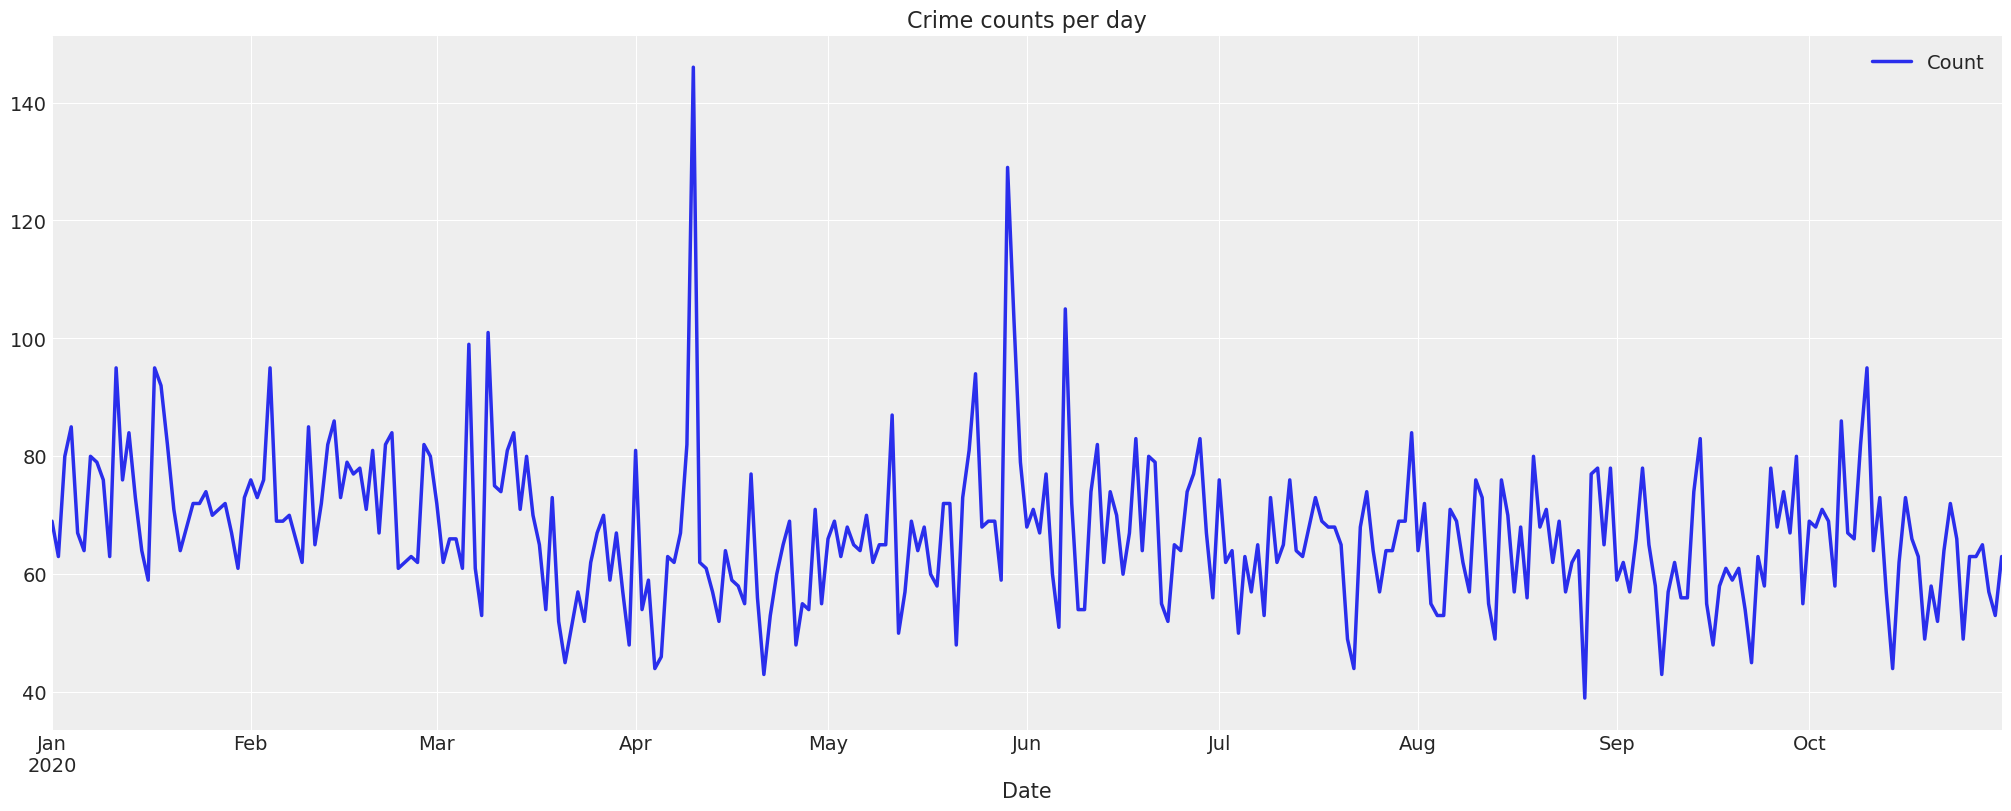

In [25]:
police.groupby(['Date']).sum().plot(figsize=(20, 8), linewidth=2.5, title='Crime counts per day');

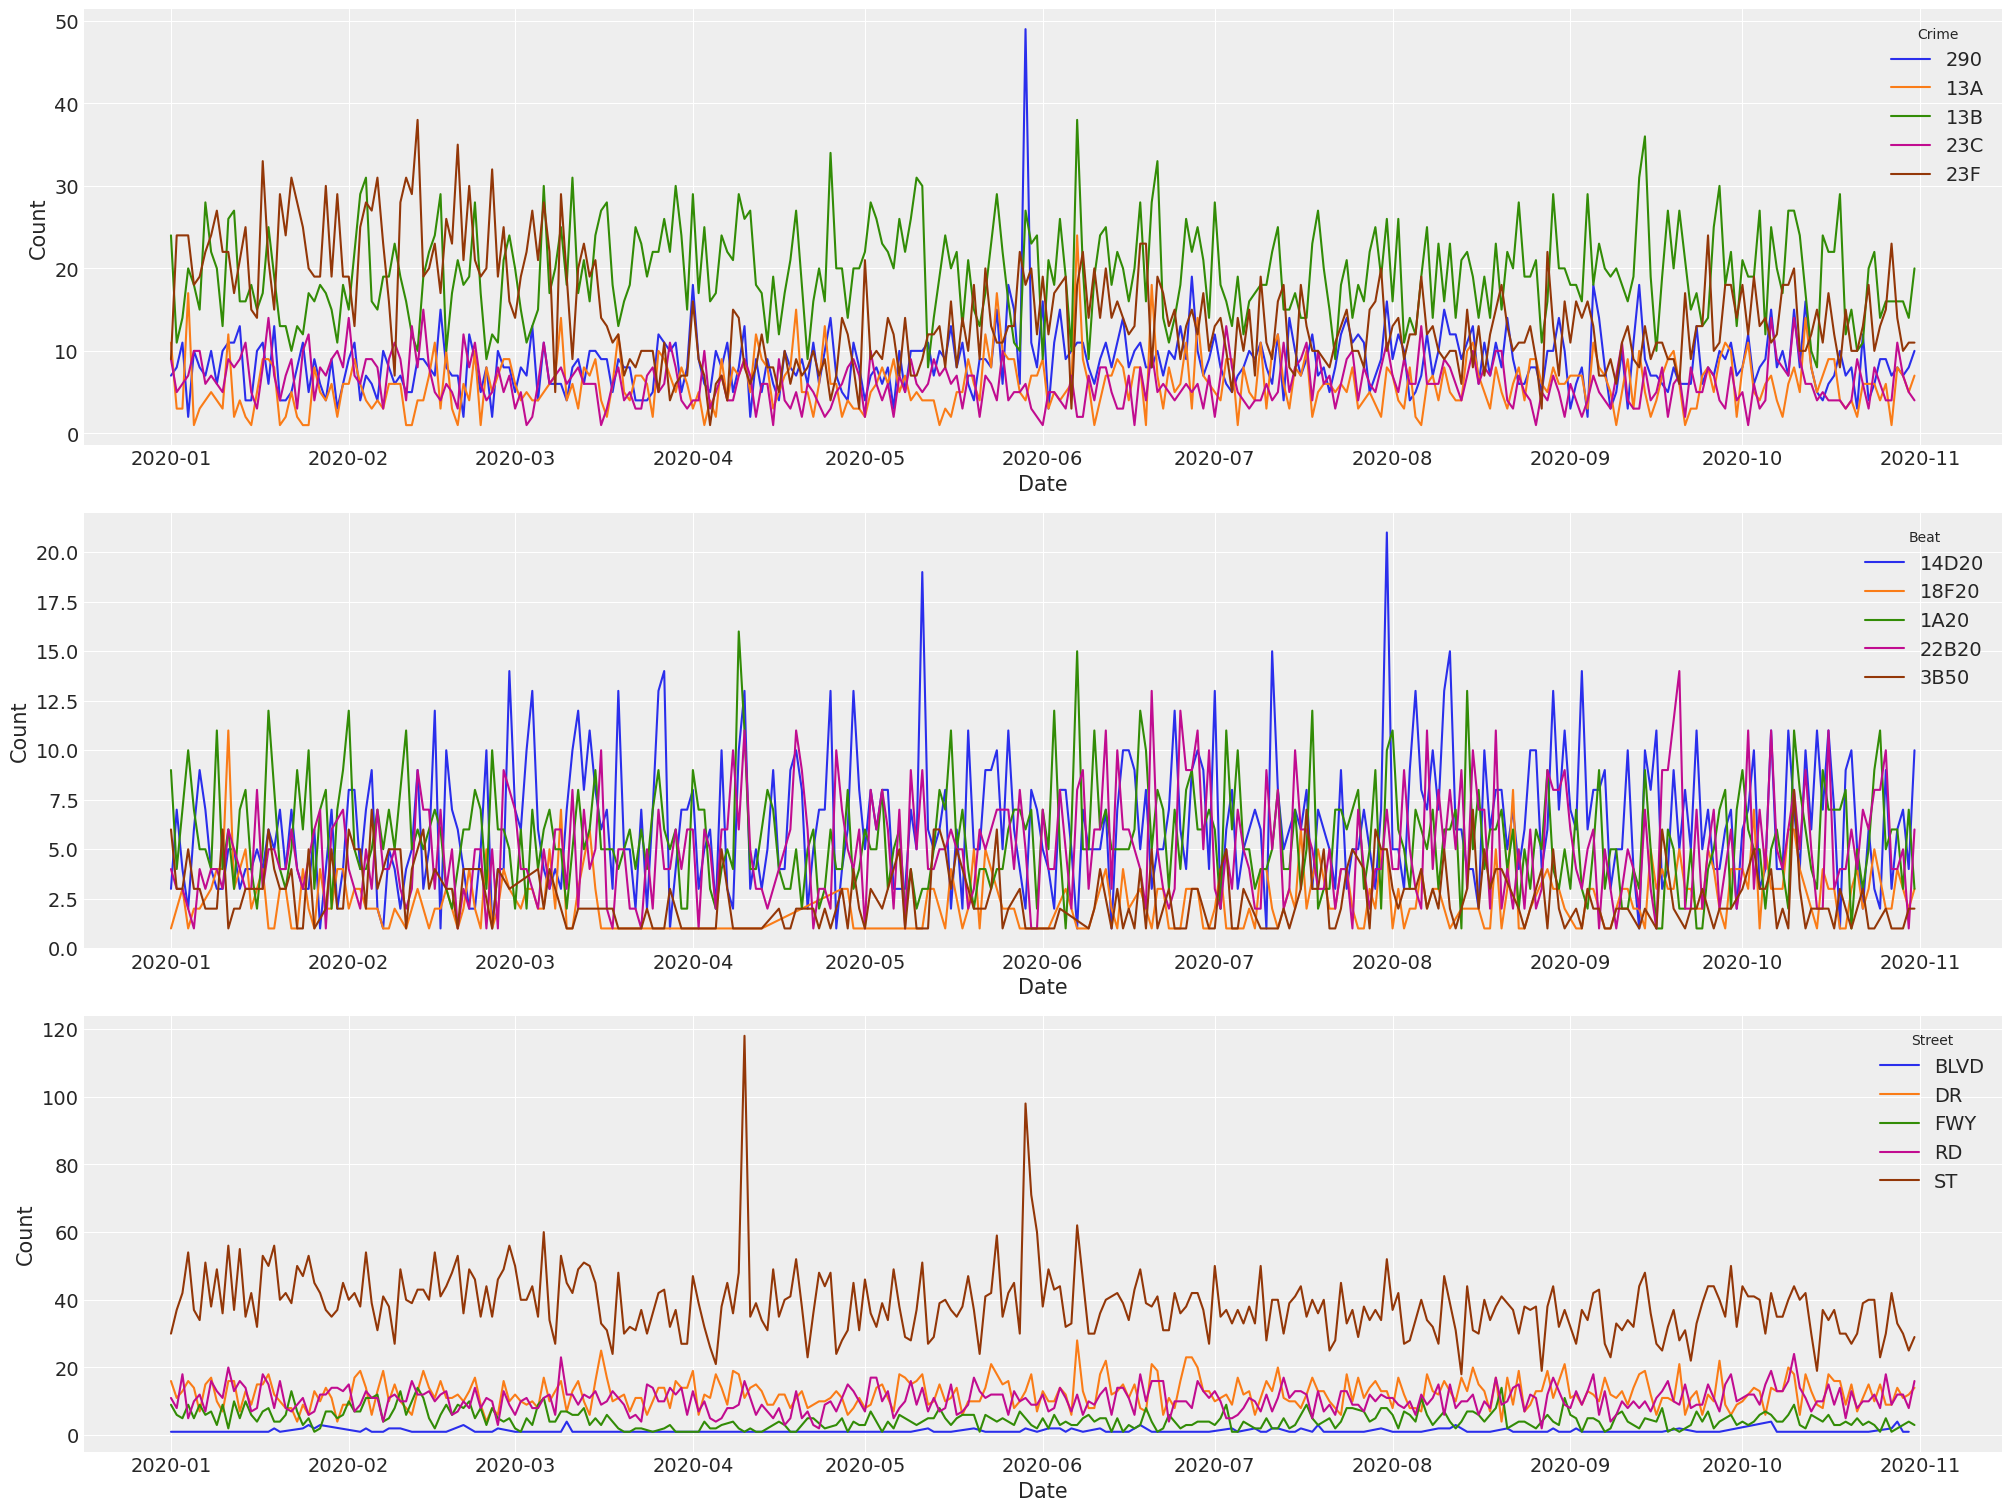

In [26]:
_, ax = plt.subplots(3, 1,figsize=(20,15))
sns.lineplot(ax = ax[0],
             data=police.loc[police['Crime'].isin(police['Crime'].unique()[:5])].groupby(['Date','Crime']).sum(), 
             x="Date", y="Count", hue="Crime");
sns.lineplot(ax = ax[1],
             data=police.loc[police['Beat'].isin(police['Beat'].unique()[:5])].groupby(['Date','Beat']).sum(), 
             x="Date", y="Count", hue="Beat");
sns.lineplot(ax = ax[2],
             data=police.loc[police['Street'].isin(police['Street'].unique()[:5])].groupby(['Date','Street']).sum(), 
             x="Date", y="Count", hue="Street");
#sns.lineplot(ax = ax[3],
#             data=police.loc[police['ZIP'].isin(police['ZIP'].unique()[:5])].groupby(['Date','ZIP']).sum(), 
#             x="Date", y="Count", hue="ZIP");

In [27]:
police_pivot = police.reset_index().pivot(index='Date',columns=['Crime', 'Beat', 'Street'], values='Count')
police_pivot = police_pivot.fillna(0)

In [28]:
groups_input = {
    'Crime': [0],
    'Beat': [1],
    'Street': [2]
}

In [29]:
groups = generate_groups_data_flat(police_pivot, groups_input, seasonality=7, h=30)

Number of groups: 3
	Crime: 10
	Beat: 42
	Street: 6
Total number of series: 100
Number of points per series for train: 275
Total number of points: 305
Seasonality: 7
Forecast horizon: 30


In [30]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  likelihood='normal')

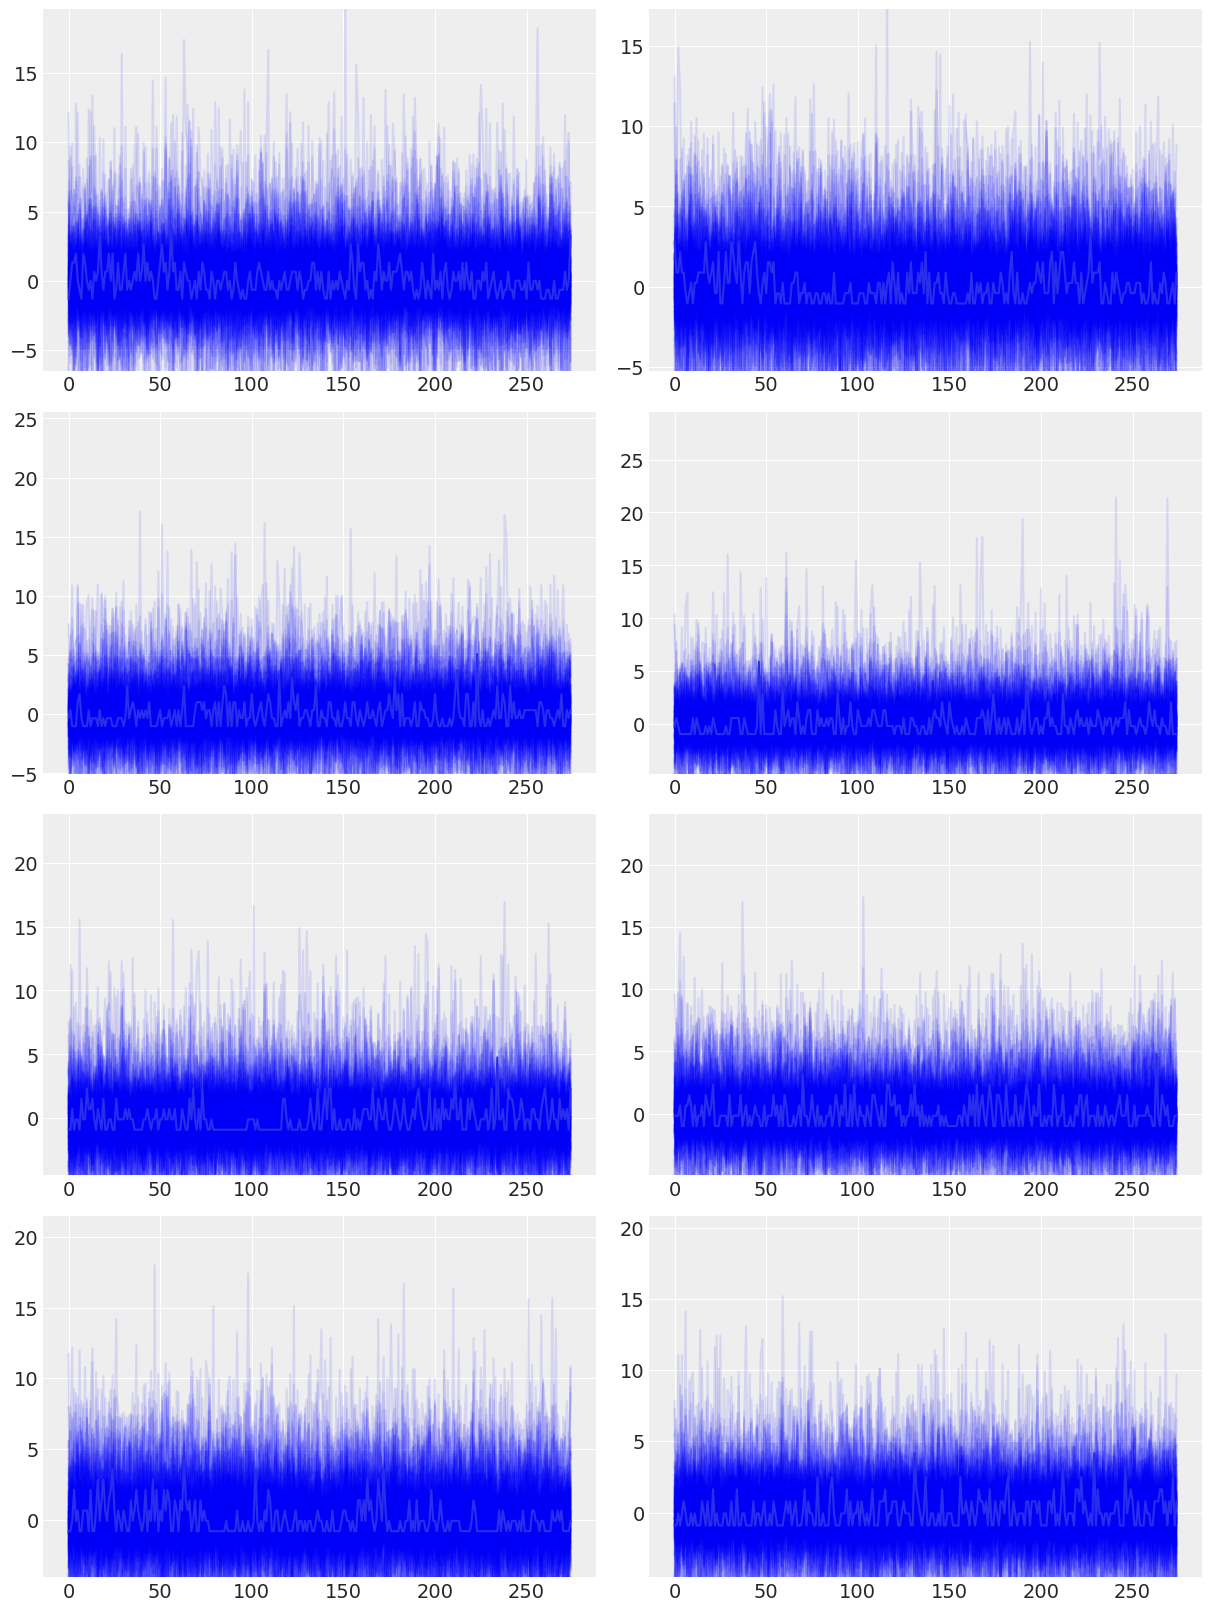

In [31]:
m.prior_predictive_checks()
visualize_prior(groups, m.prior_checks, 8)

In [ ]:
m.fit_vi()

In [ ]:
m.predict()

In [ ]:
visualize_fit(groups, m.pred_samples_fit, 8)

In [ ]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [ ]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [ ]:
metrics_to_table(groups, results)